In [1]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

# Dataset

In [2]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\joao\tensorflow_datasets\ted_hrlr_translate\pt_to_en\1.0.0.incomplete36QPWP\ted_hrlr_transl…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\joao\tensorflow_datasets\ted_hrlr_translate\pt_to_en\1.0.0.incomplete36QPWP\ted_hrlr_transl…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\joao\tensorflow_datasets\ted_hrlr_translate\pt_to_en\1.0.0.incomplete36QPWP\ted_hrlr_transl…

Dataset ted_hrlr_translate downloaded and prepared to C:\Users\joao\tensorflow_datasets\ted_hrlr_translate\pt_to_en\1.0.0. Subsequent calls will reuse this data.


In [3]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
    print('> Examples in Portuguese:')
    for pt in pt_examples.numpy():
        print(pt.decode('utf-8'))
    print()

    print('> Examples in English:')
    for en in en_examples.numpy():
        print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


## Tokenizer

We are going load a ready-to-use tokenizer that already implemented tokenization and sanitization.

In [4]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 [==============================] - 0s 2us/step


'.\\ted_hrlr_translate_pt_en_converter.zip'

In [5]:
tokenizers = tf.saved_model.load(model_name)

In [6]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [10]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
    print(en.decode('utf-8'))

print()
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
print(tokens)
    
encoded = tokenizers.en.tokenize(en_examples)
print()
print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
    print(row)
    
round_trip = tokenizers.en.detokenize(encoded)
print()
print('> This is human-readable text:')
for line in round_trip.numpy():
    print(line.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .

> This is the text split into tokens:
<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80,

Its important to note that the Tokenizer used here is a subword tokenizer, so the word *searchability* was decomposed into two tokens *b'search'* and *b'##ability'*

Now lets see how many tokens we have, and their distribution

In [11]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
    pt_tokens = tokenizers.pt.tokenize(pt_examples)
    lengths.append(pt_tokens.row_lengths())

    en_tokens = tokenizers.en.tokenize(en_examples)
    lengths.append(en_tokens.row_lengths())
    print('.', end='', flush=True)

...................................................

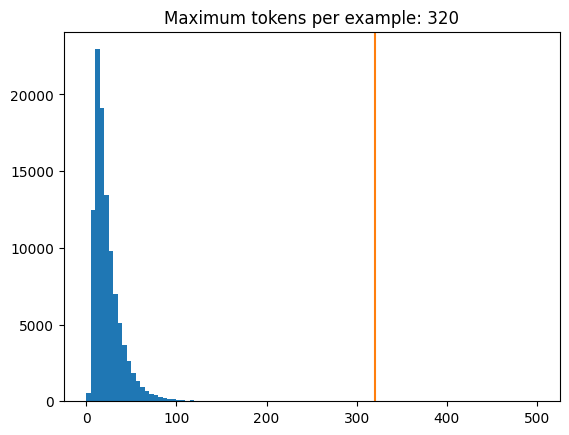

In [12]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

## Preprocess

Now, we have to preprocess the data before sending it to the model:
- Tokenize it
- Trim to max_tokens
- Split the english target into inputs and labels, both are shifted by 1 step, so that at each input, the label is the id of the next token

In [15]:
MAX_TOKENS=128
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)] # Shift 1 step
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

def make_batches(ds):
    return ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).map(prepare_batch, tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

*From Tensorflow*:

The *inputs* are pairs of tokenized Portuguese and English sequences, (pt, en). The *labels* are the same English sequences shifted by 1. This shift is so that at each location input en sequence, the label in the next token.

This is the mechanism used for traditional text generation, except here you have additional input "context" (the Portuguese sequence) that the model is "conditioned" on.

This setup is called **teacher forcing** because regardless of the model's output at each timestep, it gets the true value as input for the next timestep. This is a simple and efficient way to train a text generation model. It's efficient because you don't need to run the model sequentially, the outputs at the different sequence locations can be computed in parallel.

Maybe, you expected the input, output, pairs to simply be the Portuguese, English sequences. So, given the Portuguese sequence, the model would try to generate the English sequence.

It's possible to train a model that way. You'd need to write out the inference loop and pass the model's output **back to the input**. It's slower (time steps can't run in parallel), and a harder task to learn (the model can't get the end of a sentence right until it gets the beginning right), but it can give a more stable model because the model has to learn to correct its own errors during training.

## Apply to dataset

In [16]:
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [18]:
for (pt, en), en_labels in train_batches.take(1):
    break

print(pt.shape)
print(en.shape)
print(en_labels.shape)
print()
print(en[0][:10])
print(en_labels[0][:10])

(64, 65)
(64, 61)
(64, 61)

tf.Tensor([  2  82  90 242  81 176 106  30   0   0], shape=(10,), dtype=int64)
tf.Tensor([ 82  90 242  81 176 106  30   3   0   0], shape=(10,), dtype=int64)


You can see the *en* and *en_labels* are the same, just shifted by 1

# Architechture

Left: original Transformer architecture
Right: a 4-layer Transformer architecture

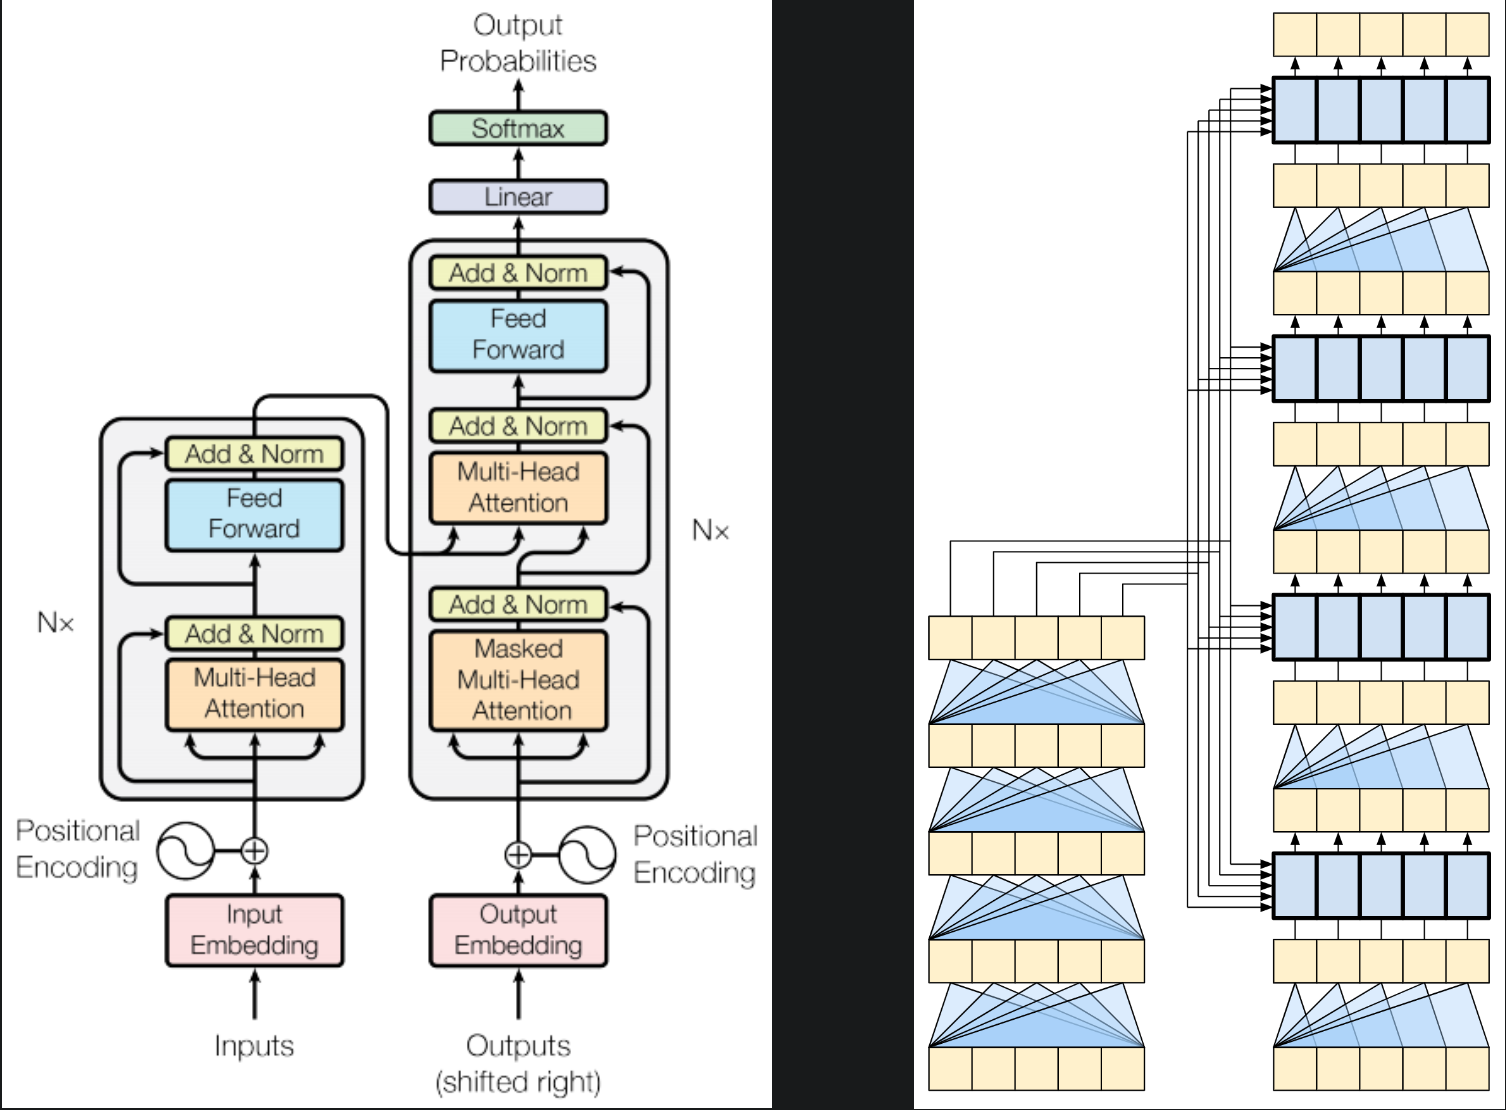

# Model Components

## Embedding and Positional Encoding

*From Tensorflow*:

The embedding is done using the *Embedding* layer.

The attention layers used throughout the model see their input as a set of vectors, with no order. Since the model doesn't contain any recurrent or convolutional layers. It needs some way to identify word order, otherwise it would see the input sequence as a bag of words instance.

A Transformer adds a "Positional Encoding" to the embedding vectors. It uses a set of sines and cosines at different frequencies (across the sequence). By definition nearby elements will have similar position encodings.

This is the original implementation:

*PE(pos, 2i) &emsp; = sin(pos/10000 <sup>2i/d_model</sup>)*

*PE(pos, 2i+1) = cos(pos/10000 <sup>2i/d_model</sup>)*

The position encoding function is a stack of sines and cosines that vibrate at different frequencies depending on their location along the depth of the embedding vector. They vibrate across the position axis.

In [19]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

(2048, 512)


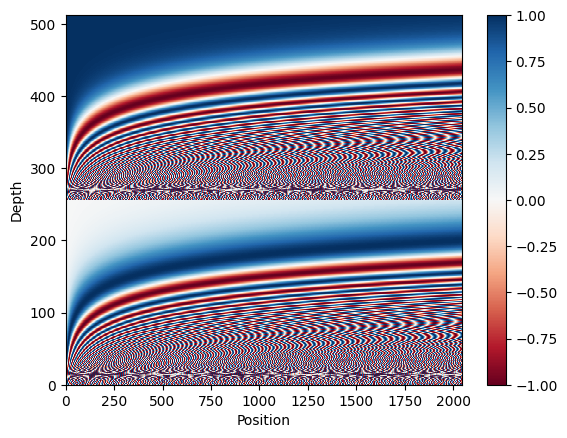

In [20]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

With this, we can create the PositionalEmbedding component

In [21]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)

        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]

        return x

In [22]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

The **Masking** is necessary in NLP because of the padding. Since padding can add "zeros" to fill out sentences smaller than the required shape, there must be a way to tell the model that certain sentence is padded and the padding part should be ignored, that whats masks are for.

In [23]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 61), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

## Add and Normalize

*From Tensorflow*:

The add and normalize blocks are simpy to join the residual connections and run the result through a *LayerNormalization*.

Since these blocks are just after the residual blocks, its easier to just add the layers in these blocks, and not write a new block.

The reason for the Add is to provide a direct path for the gradients and ensuring the input vectors to the residual blocks are **updated**, not **replaced**, by the attention layers.

The reason for the Nomrlize is to maintain a resaonable scale for the outputs.

## Feed Forward

Its a simple fedd forward head to be attached after the attention blocks

In [27]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

## Attention

### Base Attention

*From Tensorflow*:

The Attention blocks computations are identical, only differing in how the attention is configured. All Attention blocks contain a *MultiHeadAttention*, a *LayerNormalization* and a *Add* layer.

In an attention layer the *query*, *key*, and *value* are each vectors. The attention layer combines the *query* and *key* vectors to determine how well they match, the **attention score**. The layer returns the average across all the values, weighted by the **attention scores**.

The **output** length is the length of the *query* sequence, and not the length of the context *key/value* sequence.

In [24]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

### Cross Attention

*From Tensorflow*:

This layer connects the encoder to the decoder right at the middle of the model. This layer is the most straight-forward use of attention in the model, it performs the same task as the traditional RNN + Attention method.

In [ ]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

### Global Self Attention

*From Tensorflow*:

This layer is responsible for processing the context sequence, right at the start of the encoder, and propagating information along its length, so that every sequence element can directly access every other sequence element.

To implement this layer we need to pass the target sequence, x, as both the *query*, and *value* arguments to the *MultiHeadAttention* layer:

In [25]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

### Causal Self Attention

*From Tensorflow*:

This layer does a similar job as the global self attention layer, but for the output sequence, right at the start of the decoder.

Like in the traditional RNN + Attention, this layer is not **autoregressive**: They generate the text one token at a time and feed that output back to the input. To ensure this **causal** dependency, the models make the present prediction dependent only of the previous prediction.

To build a causal self attention layer, you need to use an appropriate mask when computing the attention scores and sum the attention values. This can be done if we pass *use_causal_mask=True* to the *MultiHeadAttention* layer.

In [26]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x, use_causal_mask=True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

The causal mask ensures that each location only has access to the locations that come before it.

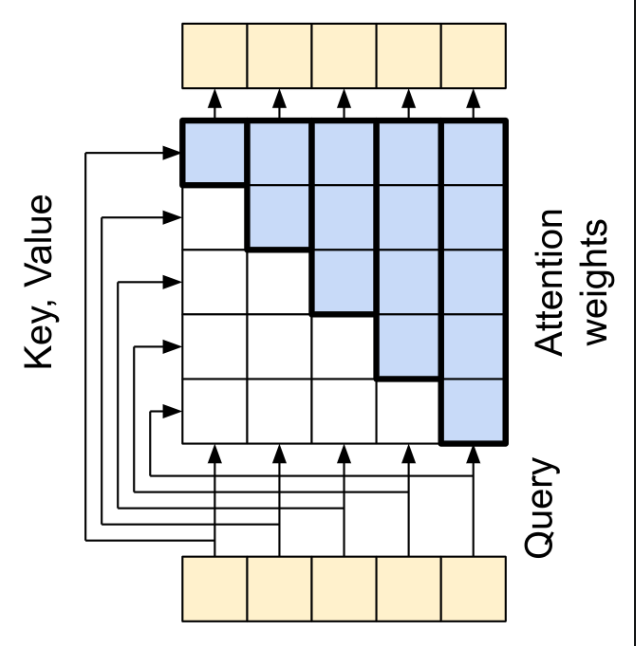

# Model

Ok, with all blocks done, we can create the model.

Since we are going to use a 4-layer Transformer, we need to replicate the Encoder-Decoder style 4 times, so we first need to wrap it up in a class, to simplify it.